In [1]:
from google.colab import drive 
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!ls "/gdrive/My Drive/Colab Notebooks"

 CNN
 datasets
'Emotion Detection (with KNN only in Colab)'
 Face_Detection
 fer2013.csv
 First_Project
'(에러 다수) Keras-tuner를 활용한 MNIST Classification (Colab-only).ipynb'
 model
'Project_Practice(lr=0.001).ipynb'
'Project_Practice(unit=256).ipynb'
'Project_Practice(unit=4096).ipynb'
 Semi-Project
'Semi-Project(Deep-Learning)'


VGG16 합성곱 기반 층만들기(P202)

In [0]:
import os

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.






58892288/58889256 [==============================] - 1s 0us/step








In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기(p204)

In [7]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/gdrive/My Drive/Colab Notebooks/datasets/cats_and_dogs_small/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

완전 연결 분류기를 정의하고 훈련하기(p205)

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 472us/step - loss: 0.5759 - acc: 0.6950 - val_loss: 0.4334 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 1s 296us/step - loss: 0.4268 - acc: 0.8075 - val_loss: 0.3651 - val_acc: 0.8480
Epoch 3/30
2000/2000 [==============================] - 1s 281us/step - loss: 0.3605 - acc: 0.8475 - val_loss: 0.3262 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 1s 274us/step - loss: 0.3193 - acc: 0.8735 - val_loss: 0.3070 - val_acc: 0.8780
Epoch 5/30
2000/2000 [==============================] - 1s 286us/step - loss: 0.2849 - acc: 0.8860 - val_loss: 0.2849 - val_acc: 0.8950
Epoch 6/30
2000/2000 [==============================] - 1s

결과 그래프 그리기(p206)

In [0]:
import matplotlib.pyplot as plt

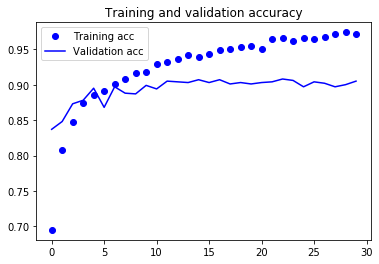

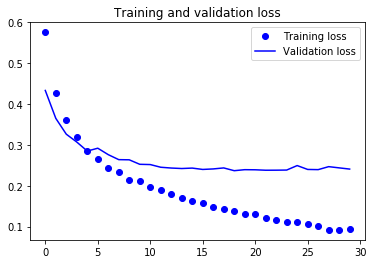

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

합성곱 기반 층 위에 완전 연결 분류기 추가하기(p208)

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [0]:
conv_base.trainable = False

In [18]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 28s - loss: 0.5514 - acc: 0.7295 - val_loss: 0.4247 - val_acc: 0.8320
Epoch 2/30
 - 25s - loss: 0.4194 - acc: 0.8190 - val_loss: 0.3476 - val_acc: 0.8670
Epoch 3/30
 - 25s - loss: 0.3570 - acc: 0.8500 - val_loss: 0.3180 - val_acc: 0.8650
Epoch 4/30
 - 25s - loss: 0.3206 - acc: 0.8680 - val_loss: 0.2937 - val_acc: 0.8820
Epoch 5/30
 - 25s - loss: 0.3072 - acc: 0.8695 - val_loss: 0.2750 - val_acc: 0.8960
Epoch 6/30
 - 25s - loss: 0.2912 - acc: 0.8805 - val_loss: 0.2702 - val_acc: 0.8890
Epoch 7/30
 - 25s - loss: 0.2759 - acc: 0.8940 - val_loss: 0.2654 - val_acc: 0.8910
Epoch 8/30
 - 25s - loss: 0.2731 - acc: 0.8880 - val_loss: 0.2568 - val_acc: 0.8970
Epoch 9/30
 - 25s - loss: 0.2609 - acc: 0.8865 - val_loss: 0.2634 - val_acc: 0.8890
Epoch 10/30
 - 25s - loss: 0.2553 - acc: 0.8980 - val_loss: 0.2557 - val_acc: 0.8970
Epoch 11/30
 - 25s - loss: 0.2395 - acc: 0.9020 - val_loss: 0.2444 - val_ac

In [0]:
model.save('/gdrive/My Drive/Colab Notebooks/model/cats_and_dogs_small_3.h5')

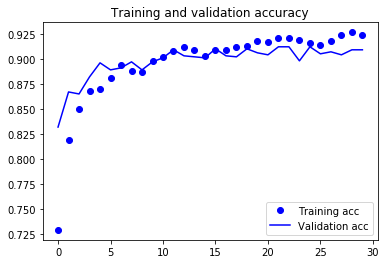

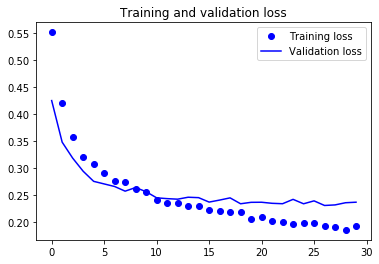

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 미세 조정

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

특정 층까지 모든 층 동결하기(p214)

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

모델 미세 조정하기 (p215)

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 29s 288ms/step - loss: 0.1946 - acc: 0.9190 - val_loss: 0.2276 - val_acc: 0.9170
Epoch 2/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1699 - acc: 0.9330 - val_loss: 0.2421 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 26s 263ms/step - loss: 0.1312 - acc: 0.9455 - val_loss: 0.2203 - val_acc: 0.9160
Epoch 4/100
100/100 [==============================] - 26s 261ms/step - loss: 0.1259 - acc: 0.9525 - val_loss: 0.2359 - val_acc: 0.9120
Epoch 5/100
100/100 [==============================] - 26s 263ms/step - loss: 0.1094 - acc: 0.9575 - val_loss: 0.2129 - val_acc: 0.9260
Epoch 6/100
100/100 [==============================] - 26s 260ms/step - loss: 0.1006 - acc: 0.9625 - val_loss: 0.2199 - val_acc: 0.9180
Epoch 7/100
100/100 [==============================] - 26s 263ms/step - loss: 0.0736 - acc: 0.9705 - val_loss: 0.2277 - val_acc: 0.9250
Epoch 8/100
100/100 [===========================

In [0]:
model.save('/gdrive/My Drive/Colab Notebooks/model/cats_and_dogs_small_4.h5')

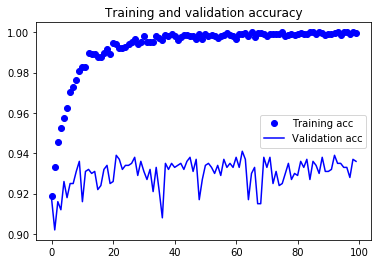

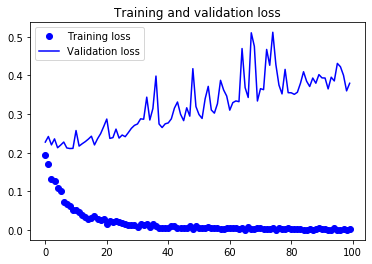

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

부드러운 그래프 그리기(p216)

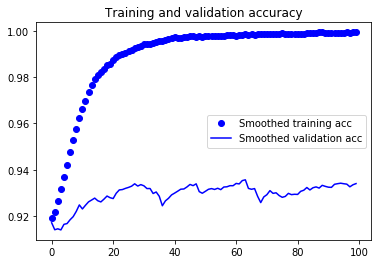

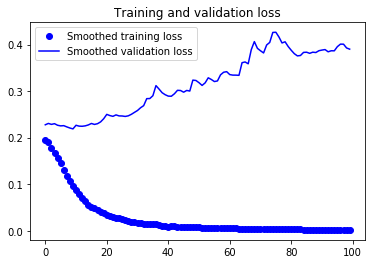

In [29]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9409999930858612
